# Load data using dataframe.

% pip install neurokit2

conda install conda-forge::neurokit2

In [ ]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

import neurokit2 as nk

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn import tree


from sklearn.model_selection import cross_val_score

# import graphviz


import os

In [26]:

def convert_units(data):
    eda = (data / 2**10) * 3.3 / 0.12
    return eda


In [27]:
# Load data in file Data/Session_3.csv into a pandas dataframe

# Load data from file

datadir = os.path.join('..', 'data')

data = pd.read_csv(os.path.join(datadir, 'session_s3.csv'))

# Sampling freq.
fs = 1000



/var/folders/nj/5_rdn90926779n4b6y3sbq9c0000gn/T/ipykernel_90359/385424809.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(datadir, 'session_s3.csv'))


In [28]:

# Display the data
data.head()

,Time,Resp,ECG,EDA,Trigger
0,0.000,513.0,511.0,20.087891,-1.0
1,0.001,514.0,511.0,20.087891,-1.0
2,0.002,514.0,511.0,20.087891,-1.0
3,0.003,513.0,511.0,20.087891,-1.0
4,0.004,514.0,511.0,20.087891,-1.0


In [29]:
data['EDA'] = convert_units(data['EDA'])


In [30]:
from scipy.signal import detrend

# remove mean and trend from Resp
data['Resp'] = detrend(data['Resp'])

# Trigger management
Transform p into -1 , and remove excess of 0 and 1

In [31]:
# change value in position i in Trigger column to -1.0 if the value in  sample i-1 was 'p', '0', or '1'



# Create a list of the indexes of the rows that need to be changed
indexes_to_change = []
for i in range(1, len(data)):
    if data.loc[i-1, 'Trigger'] in ['p', '0', '1']:
        indexes_to_change.append(i)

# Change the values in the Trigger column
data.loc[indexes_to_change, 'Trigger'] = '-1.0'

# change p in Trigger column to 9.0
data.loc[data['Trigger'] == 'p', 'Trigger'] = '-1.0'


# Convert the values in the Trigger column to float
data['Trigger'] = data['Trigger'].astype(float)

# get trigger values above -1
trigger_values = data[data['Trigger'] > -1.0]['Trigger']


print(len(trigger_values))



18


In [32]:
trigger_values

34000     1.0
62000     0.0
89000     1.0
117000    1.0
145000    0.0
173000    1.0
201000    0.0
229000    1.0
257000    1.0
286000    1.0
315000    1.0
343000    0.0
371000    1.0
400000    1.0
428000    1.0
458000    0.0
486000    1.0
515000    1.0
Name: Trigger, dtype: float64

# Data visualization

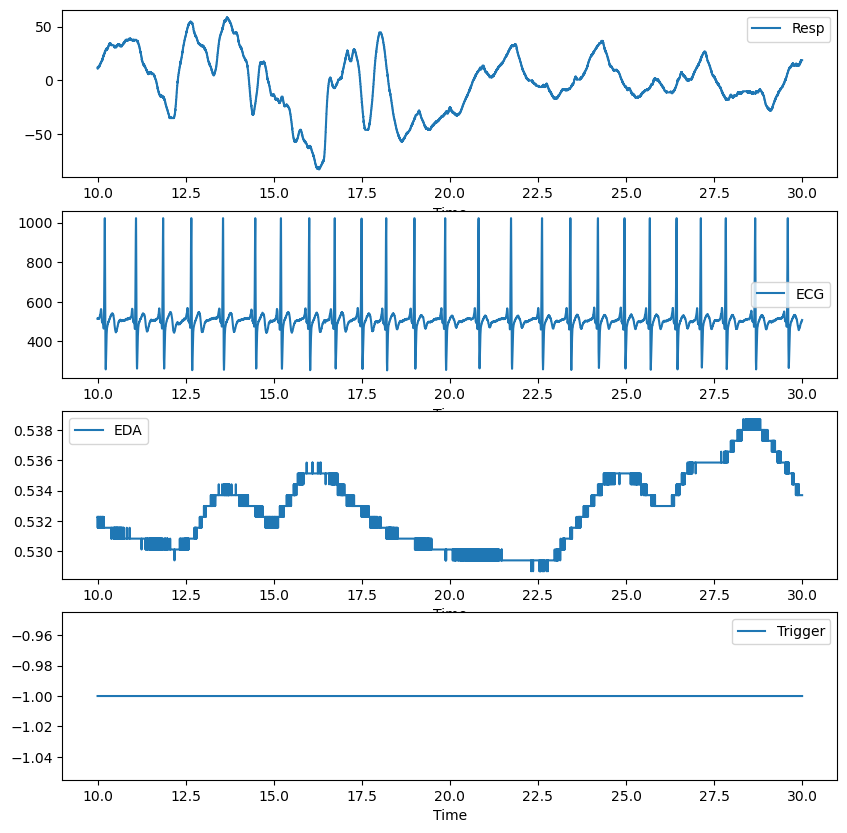

In [33]:
# plot the data, x-axis is the first column, subplots for the second, third and fourth column

offset=10000
wSize=20000

# figure with 3 subplots only show 10 seconds of data
fig, axs = plt.subplots(4, 1, figsize=(10, 10))

# plot the data
data.iloc[offset:offset+wSize].plot(x='Time', y='Resp', ax=axs[0])
data.iloc[offset:offset+wSize].plot(x='Time', y='ECG', ax=axs[1])
data.iloc[offset:offset+wSize].plot(x='Time', y='EDA', ax=axs[2])
data.iloc[offset:offset+wSize].plot(x='Time', y='Trigger', ax=axs[3])

# show the plot
plt.show()



# Extract epochs

In [34]:
# Segment data using column trigger

# find the indices where the trigger is 1 or 0
triggers = (data['Trigger'] == 1) | (data['Trigger'] == 0)
indices = np.where(triggers)[0]

# Epoch size in samples
ePreSize= 4*fs
ePosSize= 16*fs

# Segment the data into Epochs
epochs = []
for i in range(len(indices)):
    epochs.append(data.iloc[indices[i]-ePreSize:indices[i]+ePosSize])

num_epochs = len(epochs)
print(num_epochs)


18


# Resp features.

In [35]:
# compute average of segments
rMean = []
rSD = []
rMax = []
rMin = []

for ep in epochs:
    rMean.append(ep['Resp'][ePreSize:].mean()/ep['Resp'][:ePreSize].mean())
    rSD.append(ep['Resp'][ePreSize:].std()/ep['Resp'][:ePreSize].std())
    rMax.append(ep['Resp'][ePreSize:].max()/ep['Resp'][:ePreSize].max())
    rMin.append(ep['Resp'][ePreSize:].min()/ep['Resp'][:ePreSize].min())



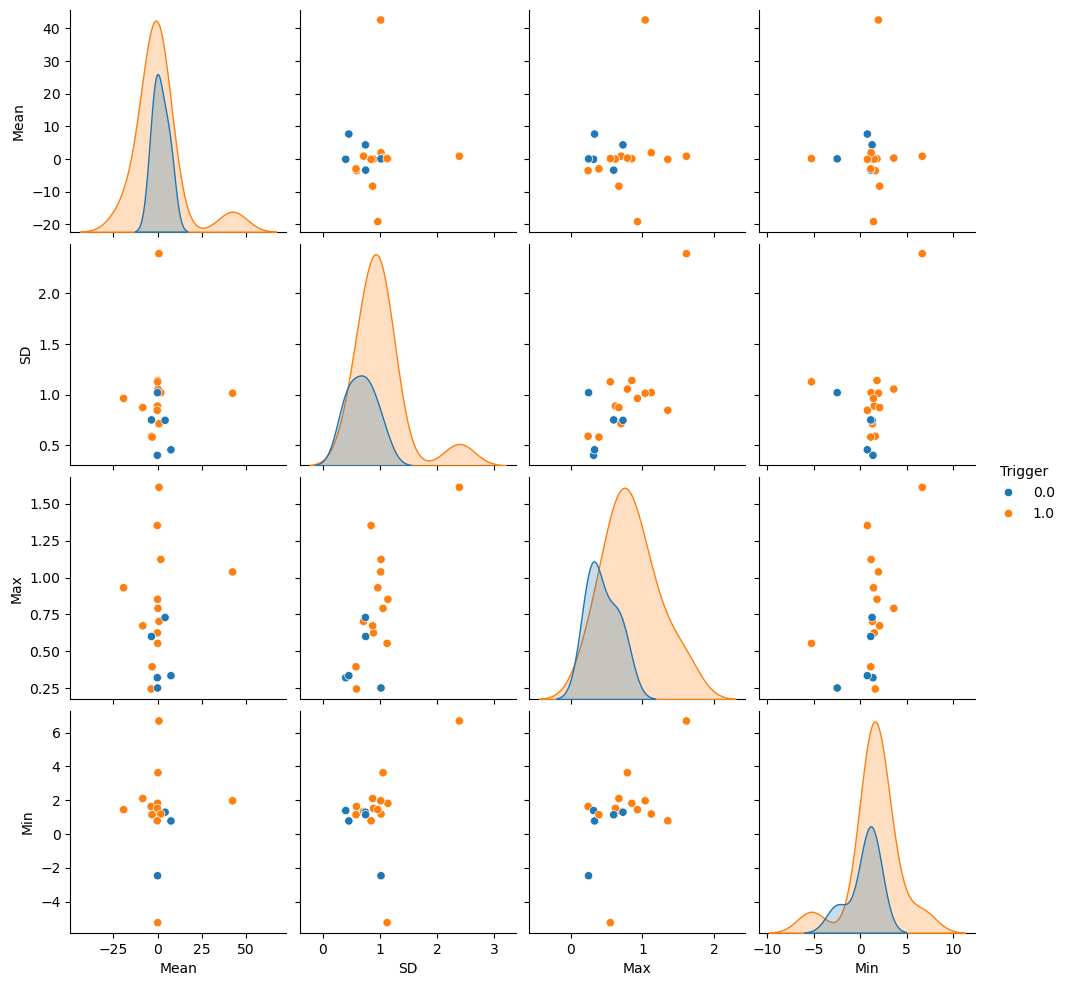

In [36]:
# show feature  grouped by trigger_values 0 and 1 using seaborn
df = pd.DataFrame({'Mean': rMean, 'SD': rSD, 'Max': rMax, 'Min': rMin, 'Trigger': trigger_values})

sns.pairplot(df, hue='Trigger')
plt.show()

# EDA features.

In [37]:

# Load data from file
eda = data['EDA']

# compute the EDA features
eda_features = nk.eda_process(eda, sampling_rate=1000)


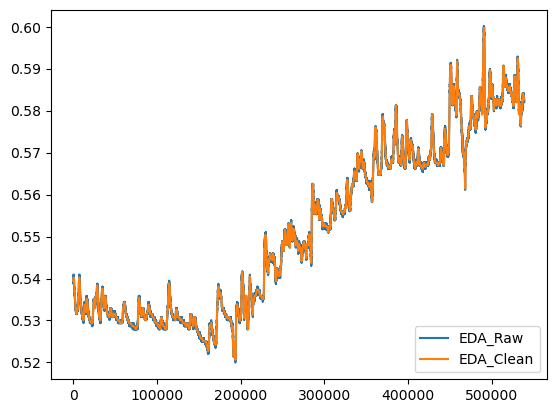

In [38]:
eda_features[0]['EDA_Raw'].plot()
eda_features[0]['EDA_Clean'].plot()
plt.legend(loc="lower right")
plt.show()


In [39]:


# Segment data using column trigger

# find the indices where the trigger is 1 or 0
triggers = (data['Trigger'] == 1) | (data['Trigger'] == 0)
indices = np.where(triggers)[0]

# Epoch size in samples

preSize= 4*fs
posSize= 16*fs

# Segment the data into Epochs
epochs = []
for i in range(len(indices)):
    epochs.append(eda_features[0].iloc[indices[i]-preSize:indices[i]+posSize])

num_epochs = len(epochs)
print(num_epochs)



18


In [40]:
# compute average of segments
edaMean = []
edaSD = []
edaMax = []
edaMin = []


for ep in epochs:
    edaMean.append(ep['EDA_Clean'][preSize:].mean()/ep['EDA_Clean'][:preSize].mean())
    edaSD.append(ep['EDA_Clean'][preSize:].std()/ep['EDA_Clean'][:preSize].std())
    edaMax.append(ep['EDA_Clean'][preSize:].max()/ep['EDA_Clean'][:preSize].max())
    edaMin.append(ep['EDA_Clean'][preSize:].min()/ep['EDA_Clean'][:preSize].min())

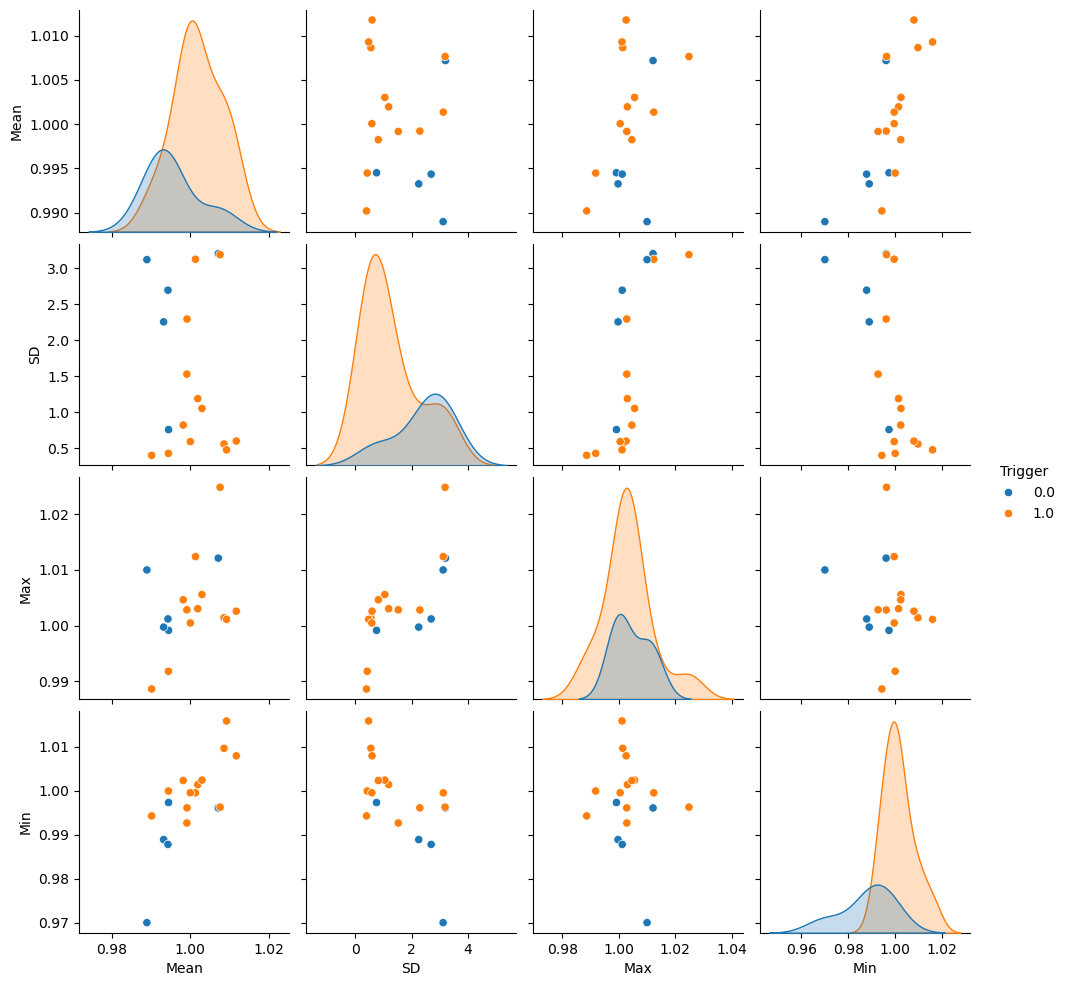

In [41]:
# show feature  grouped by trigger_values 0 and 1 using seaborn
df = pd.DataFrame({'Mean': edaMean, 'SD': edaSD, 'Max': edaMax, 'Min': edaMin, 'Trigger': trigger_values})

sns.pairplot(df, hue='Trigger')
plt.show()

# ECG

In [42]:
ecg_cleaned = nk.ecg_clean(data['ECG'], sampling_rate=1000)

instant_peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=1000)
_, waves_peak = nk.ecg_delineate(data['ECG'], rpeaks, sampling_rate=1000, method="peak")

rate = nk.ecg_rate(rpeaks, sampling_rate=1000, desired_length=len(ecg_cleaned))
quality = nk.ecg_quality(ecg_cleaned, sampling_rate=1000)


# Prepare output
signals = pd.DataFrame({"ECG_Raw": data['ECG'],
                        "ECG_Clean": ecg_cleaned,
                        "ECG_Rate": rate,
                        "ECG_Quality": quality})


signals = pd.concat([signals, instant_peaks], axis=1)

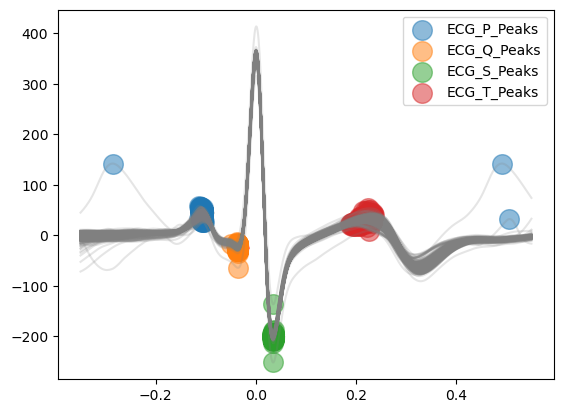

In [43]:
signal_dwt, waves_dwt = nk.ecg_delineate(signals,
                                        rpeaks,
                                        sampling_rate=1000,
                                        method="dwt",
                                        show=True,
                                        show_type='peaks')

In [44]:
epochs=[]

# Process the data for event-related analysis
df, info = nk.bio_process(ecg=signals['ECG_Clean'], sampling_rate=1000)


events = nk.events_find(data["Trigger"], threshold=-1.0, event_conditions=trigger_values.values, threshold_keep='above')

epochs = nk.epochs_create(signals, events, sampling_rate=1000, epochs_start=-1.0, epochs_end=7.0)

# Analyze
analyze_epochs = nk.ecg_analyze(epochs, sampling_rate=1000)

# Get a dataframe with all the results

analyze_epochs

/Users/brunoleitao/anaconda3/envs/BESTcourse/lib/python3.12/site-packages/neurokit2/ecg/ecg_eventrelated.py:133: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` or `ECG_Phase_Ventricular` column. Will not indicate whether event onset concurs with cardiac phase.
  warn(
/Users/brunoleitao/anaconda3/envs/BESTcourse/lib/python3.12/site-packages/neurokit2/ecg/ecg_eventrelated.py:133: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` or `ECG_Phase_Ventricular` column. Will not indicate whether event onset concurs with cardiac phase.
  warn(
/Users/brunoleitao/anaconda3/envs/BESTcourse/lib/python3.12/site-packages/neurokit2/ecg/ecg_eventrelated.py:133: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` or `ECG_Phase_Ventricular` column. Will not indicate whether event onset concurs with cardiac phase.
  warn(
/Users/brunoleitao/anaconda3/envs/BESTcourse/lib/python3.12/site-packages/neurokit2/ecg/ecg_eventrelated.py:133: NeuroKitWarning: Input does not have an `

,Label,Condition,Event_Onset,ECG_Rate_Baseline,ECG_Rate_Max,ECG_Rate_Min,ECG_Rate_Mean,ECG_Rate_SD,ECG_Rate_Max_Time,ECG_Rate_Min_Time,ECG_Rate_Trend_Linear,ECG_Rate_Trend_Quadratic,ECG_Rate_Trend_R2,ECG_Quality_Mean
1,1,1.0,34000,71.851279,-0.014039,-13.619570,-9.058972,2.317999,0.001125,7.000000,-1.033393,-6.641587,0.218179,0.958704
2,2,0.0,62000,82.286777,2.578853,-23.864187,-17.894691,7.337774,0.304163,6.116890,-10.570473,0.401121,0.819401,0.963100
3,3,1.0,89000,70.884384,6.936627,-13.904327,-3.502383,6.669083,2.065383,3.991624,-4.124568,6.127823,0.417112,0.704529
4,4,1.0,117000,62.647238,2.998276,-5.667181,-1.343145,2.457678,1.315289,5.330791,-1.680579,1.287868,0.143169,0.947317
5,5,0.0,145000,61.014094,0.750348,-4.088098,-1.652117,1.464661,7.000000,3.194524,-1.959052,0.092156,0.711827,0.983145
6,6,1.0,173000,68.208999,11.578235,-9.037402,-2.423636,7.177510,0.692212,4.359670,-7.368933,12.827004,0.751678,0.970622
7,7,0.0,201000,62.704195,-0.001718,-6.890242,-3.495174,2.304267,0.001125,6.143893,-1.358548,0.190585,0.633733,0.954282
8,8,1.0,229000,62.463829,11.793597,-1.857768,1.405865,3.602324,1.364296,4.255657,-1.689488,5.272613,0.223654,0.963652
9,9,1.0,257000,69.216605,7.119272,-14.069547,-5.271299,7.541874,1.414302,2.502438,-5.327287,6.935061,0.509336,0.921125
10,10,1.0,286000,55.459281,12.722537,-0.006416,4.555093,2.338146,6.942993,0.036130,-0.434846,4.366350,0.093249,0.945260


In [45]:
test = epochs['1']['ECG_Clean']
df, _ = nk.bio_process(test, sampling_rate=1000)
df

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,83.228123,-90.749195,62.351544,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,54.466316,-110.324470,62.351544,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,26.262010,-129.743000,62.351544,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,-1.047293,-148.851589,62.351544,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,-27.156595,-167.502992,62.351544,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,-7.703319,1.331339,59.055118,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
7996,-7.726154,1.271780,59.055118,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
7997,-7.751492,1.210680,59.055118,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
7998,-7.779331,1.148537,59.055118,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


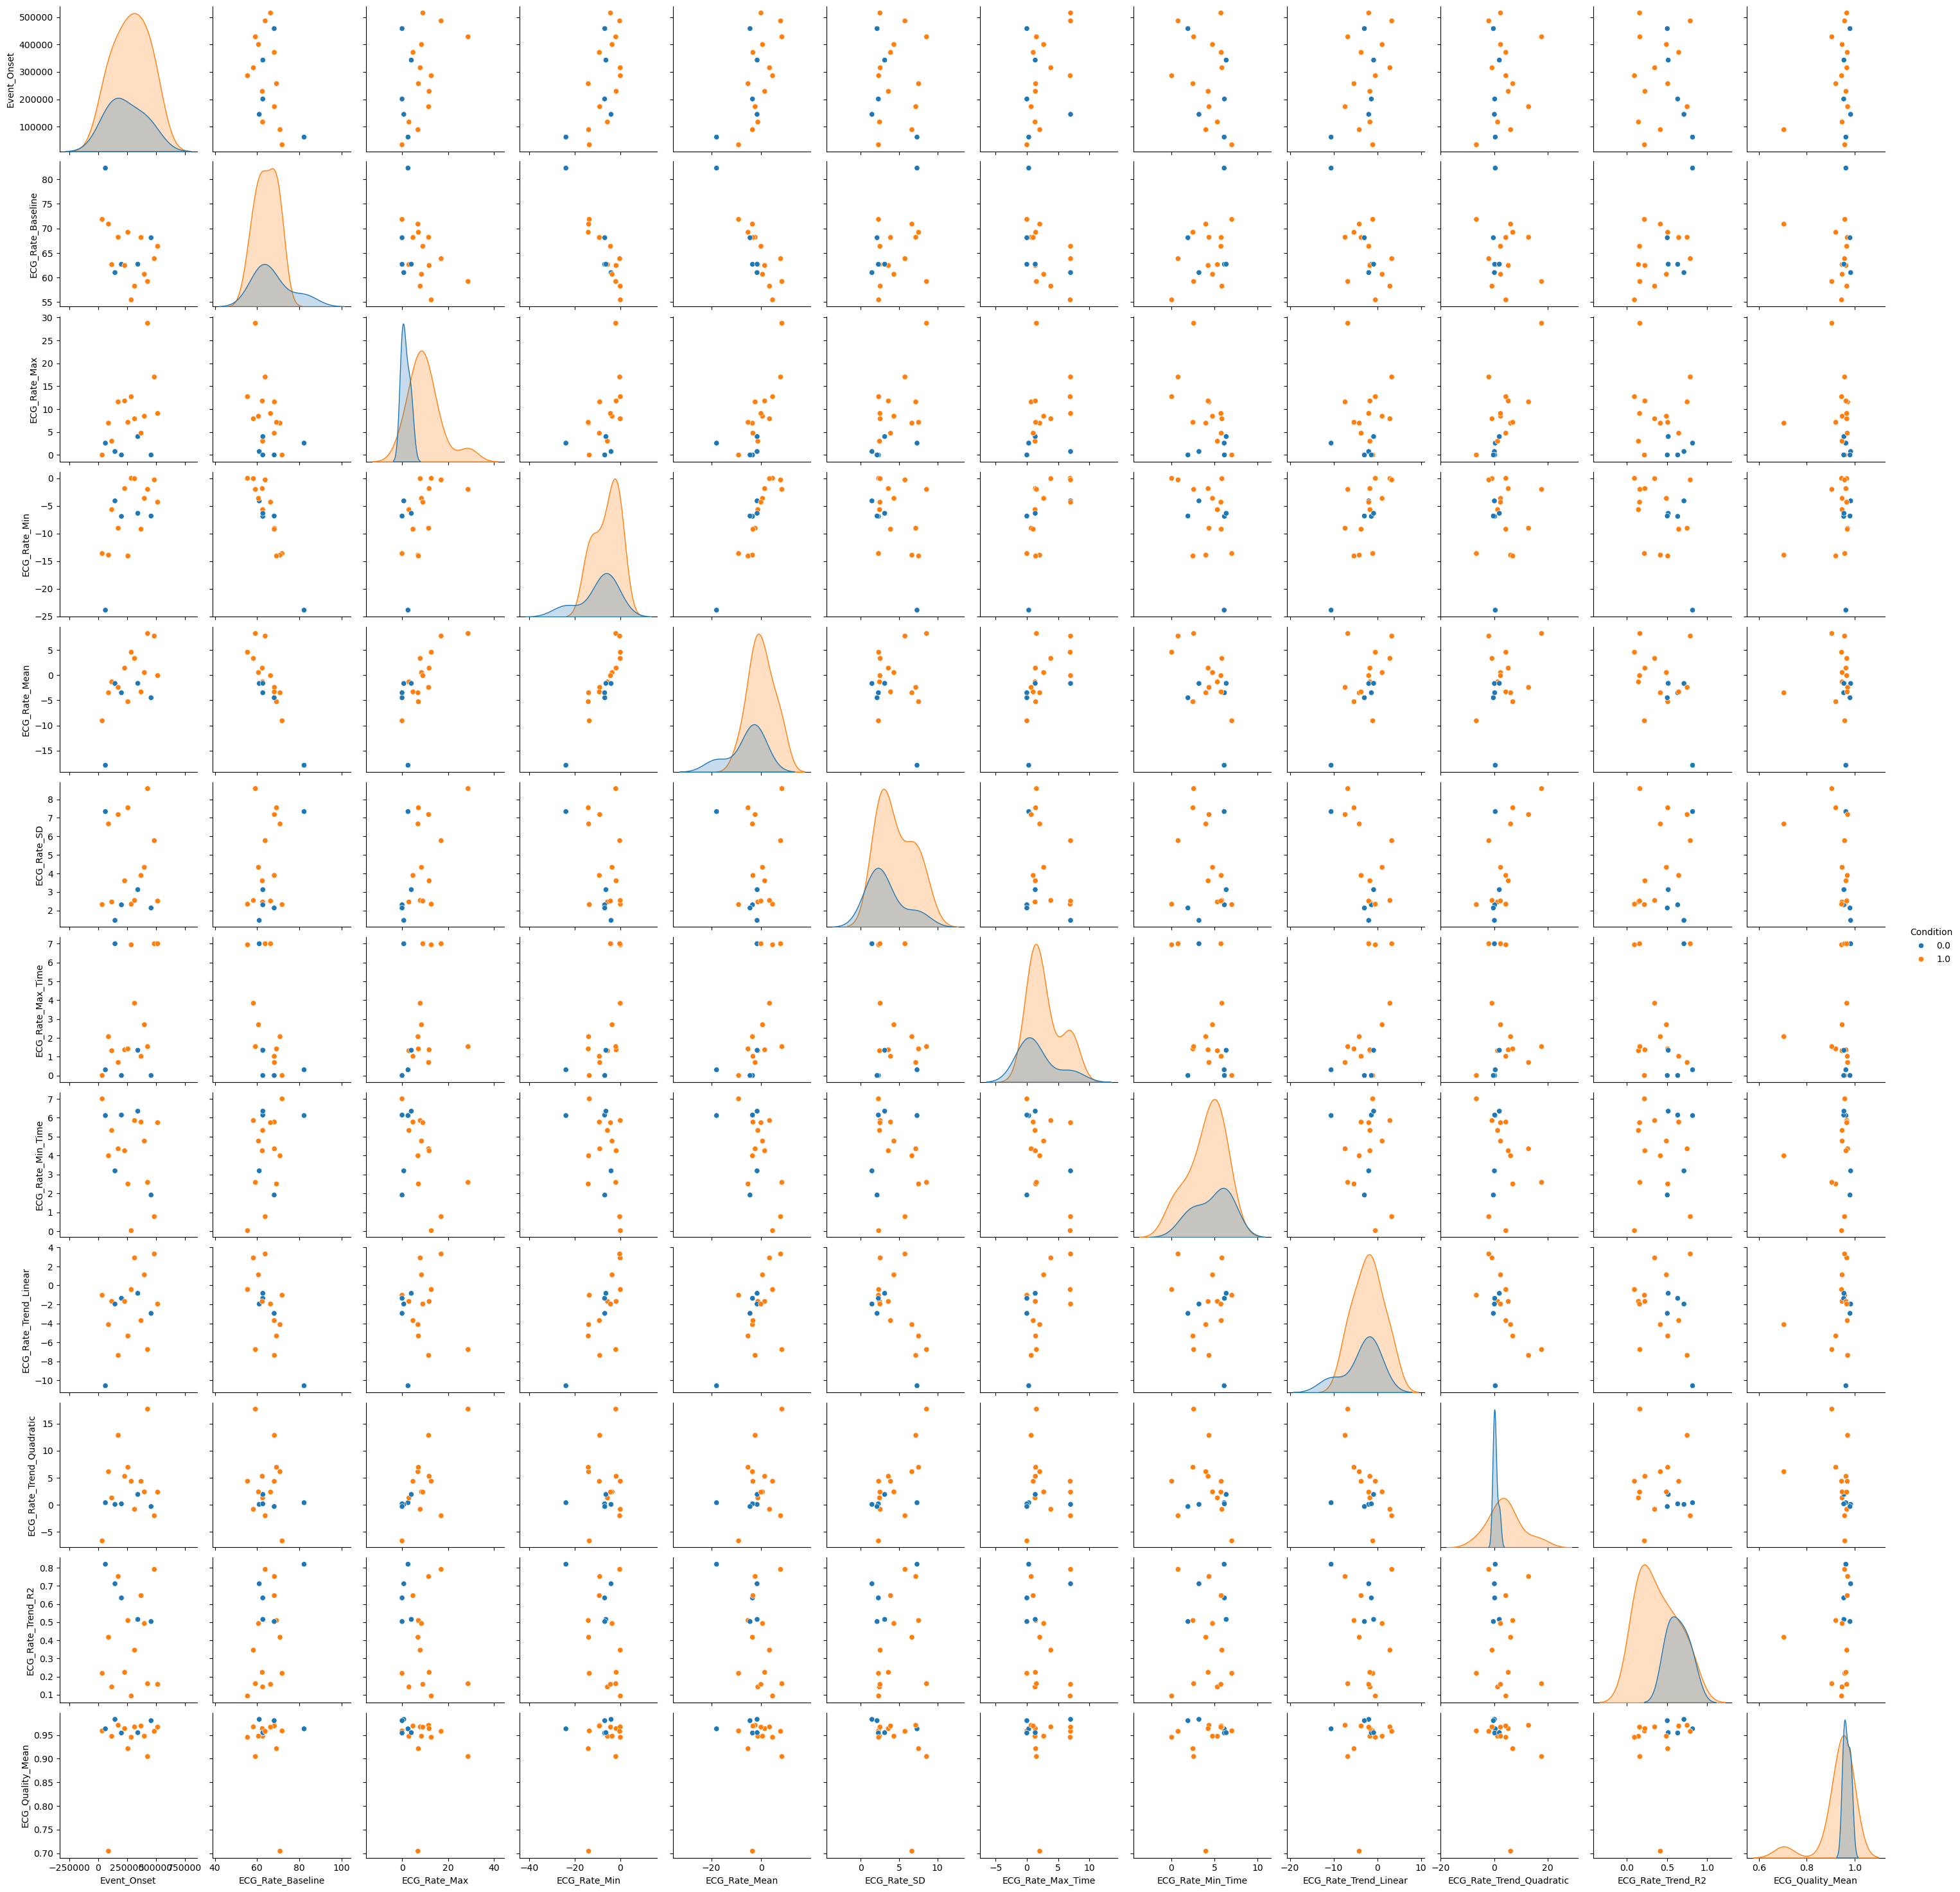

In [46]:
# show feature  grouped by trigger_values 0 and 1 using seaborn


sns.pairplot(analyze_epochs, hue='Condition')
plt.show()

In [47]:
analyze_epochs.columns

Index(['Label', 'Condition', 'Event_Onset', 'ECG_Rate_Baseline',
       'ECG_Rate_Max', 'ECG_Rate_Min', 'ECG_Rate_Mean', 'ECG_Rate_SD',
       'ECG_Rate_Max_Time', 'ECG_Rate_Min_Time', 'ECG_Rate_Trend_Linear',
       'ECG_Rate_Trend_Quadratic', 'ECG_Rate_Trend_R2', 'ECG_Quality_Mean'],
      dtype='object')

<Axes: xlabel='Condition', ylabel='ECG_Rate_Max'>

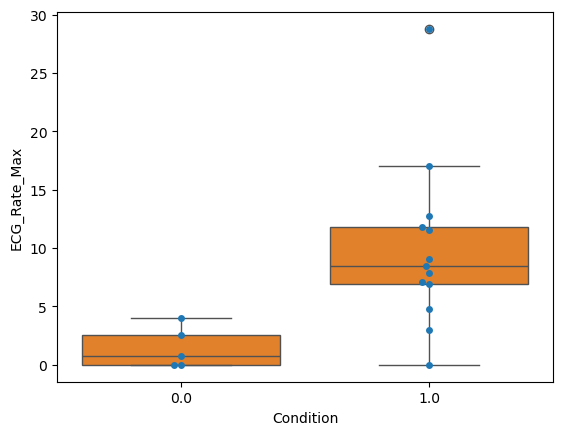

In [48]:
# show feature ECG_Rate_Baseline grouped by condition 0 and 1 using seaborn with points
#sns.swarmplot(x='Condition', y='ECG_Rate_Baseline', data=analyze_epochs)
#sns.boxplot(x='Condition', y='ECG_Rate_Baseline', data=analyze_epochs)



sns.swarmplot(x='Condition', y='ECG_Rate_Max', data=analyze_epochs)
sns.boxplot(x='Condition', y='ECG_Rate_Max', data=analyze_epochs)




# Classifier - decision tree and graph design

# Create array X with the features and array y with the target variable
X = analyze_epochs[['ECG_Rate_Baseline',
       'ECG_Rate_Max', 'ECG_Rate_Min', 'ECG_Rate_Mean', 'ECG_Rate_SD',
       'ECG_Rate_Max_Time', 'ECG_Rate_Min_Time', 'ECG_Rate_Trend_Linear',
       'ECG_Rate_Trend_Quadratic', 'ECG_Rate_Trend_R2', 'ECG_Quality_Mean']]

# Add coumns to X with the EDA features
X['EDA_Mean'] = edaMean
X['EDA_SD'] = edaSD
X['EDA_Max'] = edaMax
X['EDA_Min'] = edaMin

# Add column to X with the Resp features
X['Resp_Mean'] = rMean
X['Resp_SD'] = rSD
X['Resp_Max'] = rMax
X['Resp_Min'] = rMin


y = analyze_epochs['Condition']


model = DecisionTreeClassifier(max_depth=7, random_state=0)

model.fit(X, y)

scores = cross_val_score(estimator=model,
                         X=X,
                        y=y,
                        cv=3,
                        scoring='accuracy')


print(scores, scores.mean())
import pickle

with open('x.pkl','wb') as f:
    pickle.dump(X,f)


with open('y.pkl','wb') as f:
    pickle.dump(y,f)


# save
with open('model.pkl','wb') as f:
    pickle.dump(model,f)



# Use svm as classifier
from sklearn.svm import SVC

svmmodel = SVC()

scores = cross_val_score(estimator=svmmodel,
                         X=X,
                        y=y,
                        cv=3,
                        scoring='accuracy')

print(scores, scores.mean())

model.fit(X, y)

In [54]:
model.predict(X)

array([1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       1.])


dot_data = tree.export_graphviz(model,
                  feature_names=X.columns,
                  class_names=['0', '1'],
                  filled=True,
                  rounded=True,
                  special_characters=True,
                out_file=None,
                           )
graph = graphviz.Source(dot_data)
graph
